In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [5]:
# Cargar los datos
df = pd.read_csv('Aportes.csv', parse_dates=True, index_col='Date')
df_test = pd.read_csv('Aportes_2.csv', parse_dates=True, index_col='Date')

In [6]:
# Preprocesamiento
df.drop(['Name', 'Year', 'Month', 'PosibleNino', 'PosibleNina'], axis=1, inplace=True)
df_test.drop(['Name', 'Year', 'Month', 'PosibleNino', 'PosibleNina'], axis=1, inplace=True)
df['ValorAnterior'] = df['AporCaudal'].shift(1)
df_test['ValorAnterior'] = df_test['AporCaudal'].shift(1)
df.drop(['Temperaturas', 'Humedades'], axis=1, inplace=True)
df_test.drop(['Temperaturas', 'Humedades'], axis=1, inplace=True)
df.fillna(df.mean(), inplace=True)
df_test.fillna(df_test.mean(), inplace=True)

In [7]:
# Separar variables predictoras y objetivo
X_train = df.drop(columns=['AporCaudal']).values
y_train = df['AporCaudal'].values
X_test = df_test.drop(columns=['AporCaudal']).values
y_test = df_test['AporCaudal'].values

In [8]:
# Escalado de datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# Definir el modelo
RF = RandomForestRegressor(random_state=0)

In [19]:
# Definir la rejilla de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200, 300],  # Número de árboles
    'max_depth': [5, 10, 15, 20],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Muestras mínimas para dividir un nodo
    'min_samples_leaf': [1, 2, 4]  # Muestras mínimas en una hoja
}

In [20]:
# Optimización de hiperparámetros
random_search_RF = RandomizedSearchCV(RF, param_grid, cv=5, random_state=0)
random_search_RF.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
                   param_distributions={'max_depth': [5, 10, 15, 20],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300]},
                   random_state=0)

In [30]:
# Obtener el mejor modelo
best_idx = np.argmax(random_search_RF.cv_results_['mean_test_score'])
best_model_RF = random_search_RF.best_estimator_
best_params_random = random_search_RF.best_params_
best_score_RF = random_search_RF.best_score_

In [31]:
# Imprimir información sobre el mejor modelo
print("Índice del mejor modelo:", best_idx)
print("Mejores parámetros:", best_params_random)
print("Mejor desempeño en validación cruzada (R2):", best_score_RF)

Índice del mejor modelo: 7
Mejores parámetros: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 5}
Mejor desempeño en validación cruzada (R2): 0.6085004220921173


In [32]:
# Predicción con el mejor modelo
y_pred_best_RF = best_model_RF.predict(X_test)

In [33]:
# Evaluar el modelo
r2_test = metrics.r2_score(y_test, y_pred_best_RF)
print("R2_score en test:", r2_test)
print("MAE:", metrics.mean_absolute_error(y_test, y_pred_best_RF))
print("MSE:", metrics.mean_squared_error(y_test, y_pred_best_RF))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, y_pred_best_RF)))

R2_score en test: -0.2744570523317742
MAE: 7.382594327682046
MSE: 66.40304075961966
RMSE: 8.148806094123216


In [34]:
# Funciones para graficar predicciones
def plot_pred_train(model):
    plt.figure(figsize=(20,6))
    plt.plot(df.index[8100:], df['AporCaudal'][8100:], label='Aportes Reales', color='blue', alpha=0.5)
    plt.plot(df.index[8100:], model.predict(X_train)[8100:], label='Aportes Pred', color='red', alpha=0.5)
    plt.xlabel('Date')
    plt.ylabel('m3/s')
    plt.legend()
    plt.show()

def plot_pred_test(model):
    aporte_real = df_test['AporCaudal'].values
    aporte_pred = model.predict(X_test)
    
    plt.figure(figsize=(20,6))
    plt.plot(aporte_real[:15], label='Aportes Reales', color='black', alpha=0.7)
    plt.plot(aporte_pred[:15], label='Aportes Pred', color='red', alpha=0.7)
    plt.xlabel('Date')
    plt.ylabel('m3/s')
    plt.legend()
    plt.show()

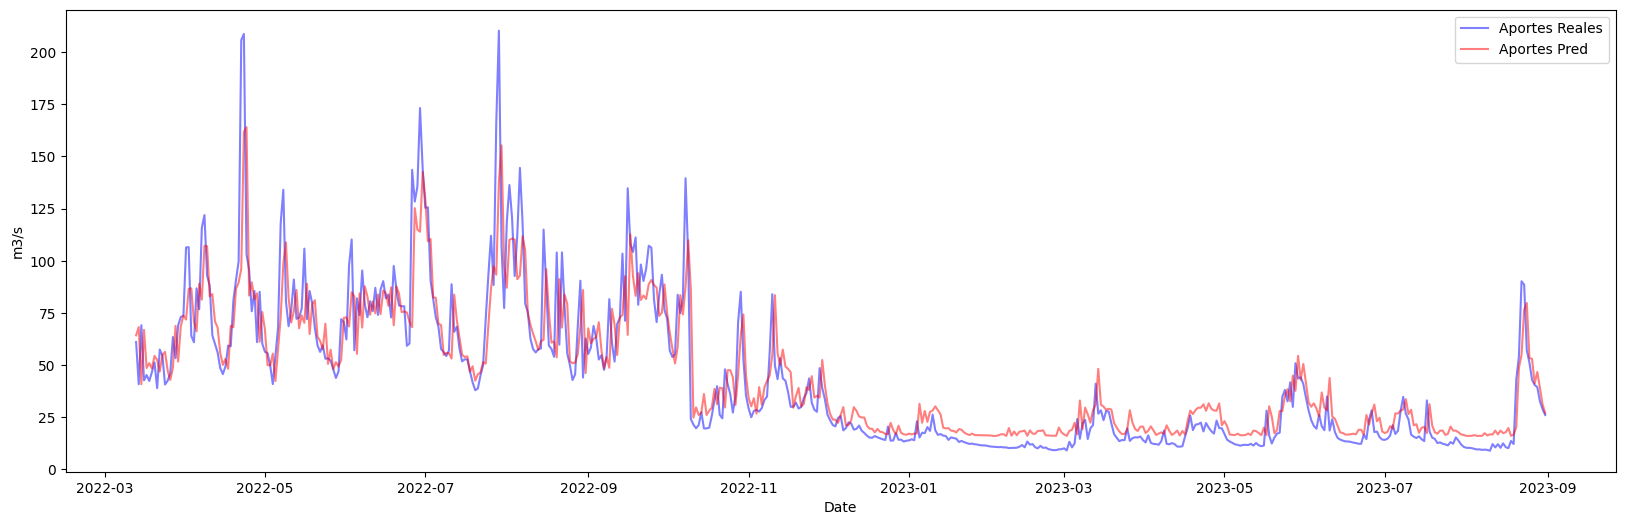

In [35]:
plot_pred_train(best_model_RF)

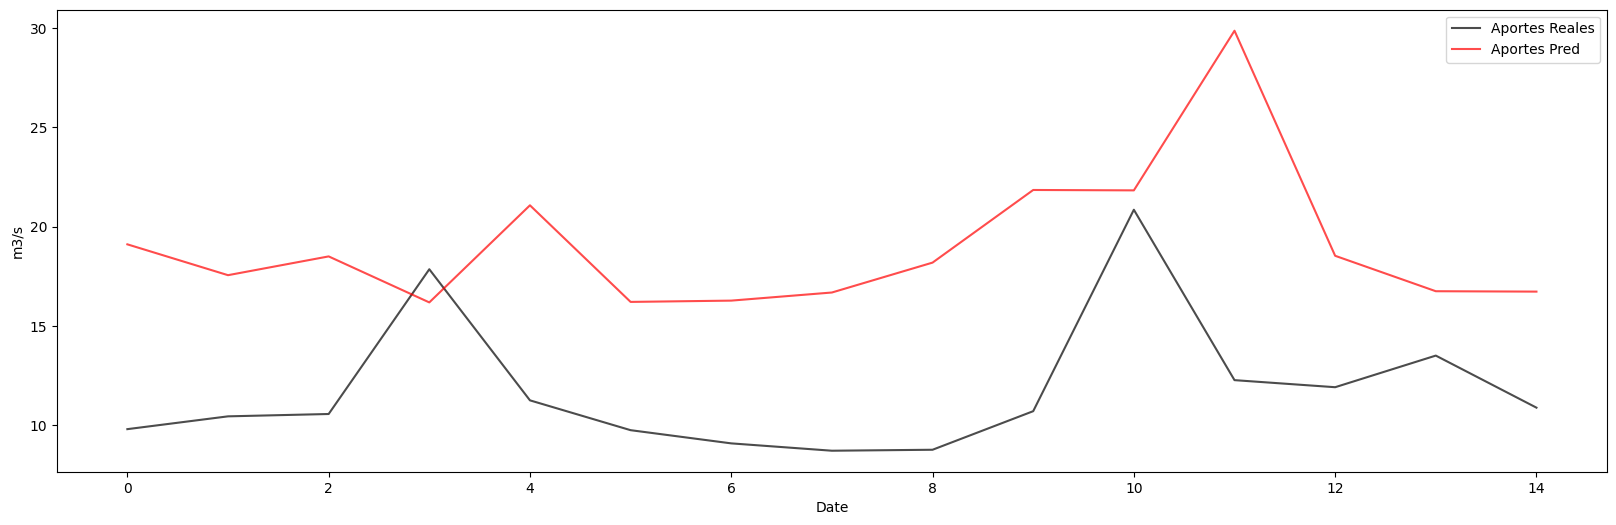

In [36]:
plot_pred_test(best_model_RF)